In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import torch
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.benchmark = False

In [3]:
torch.cuda.is_available()

True

In [4]:
outcome='pd_true'

In [5]:
import torch

cuda = torch.device('cuda')     # Default CUDA device
cuda0 = torch.device('cuda:0')
cuda1 = torch.device('cuda:1')  


# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device(cuda)

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(cuda))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA RTX A6000


In [6]:
prefix = './'

In [7]:
all_reports = pd.read_csv(prefix + 'timc_recist_labeled_dataset_id.csv')
all_reports['report_length'] = all_reports.report_text.str.len()
all_reports['date'] = pd.to_datetime(all_reports.date)
all_reports = all_reports.sort_values(by=['obs','dfci_mrn','date'])
all_reports['text'] = all_reports["report_text"]
all_reports['text'] = all_reports.text.str.lower().str.replace("\r|\n", " ")
all_reports['text'] = all_reports.text.str.replace('\s+', ' ')

/tmp/ipykernel_14856/1554159933.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  all_reports['text'] = all_reports.text.str.lower().str.replace("\r|\n", " ")
/tmp/ipykernel_14856/1554159933.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  all_reports['text'] = all_reports.text.str.replace('\s+', ' ')


In [8]:
# remove
all_reports = all_reports.drop_duplicates(subset=['dfci_mrn','text'])

In [9]:
all_reports.shape

(63897, 14)

In [10]:
all_reports['starttime'] = all_reports.groupby('obs').date.transform('first')
all_reports['time'] =  (all_reports['date'] - all_reports['starttime']).dt.days

In [11]:
all_reports.shape

(63897, 16)

In [12]:
all_reports.overall_response_factor.value_counts()

3    20140
0    15935
1    15396
4     9188
2     3238
Name: overall_response_factor, dtype: int64

In [13]:
all_reports.overall_response.value_counts()

SD    20140
BL    15935
PR    15396
PD     9188
CR     3238
Name: overall_response, dtype: int64

In [14]:
all_reports['prcr_true'] = np.where(all_reports.overall_response.isin(['PR','CR']), 1, 0)
all_reports['pd_true'] = np.where(all_reports.overall_response == 'PD', 1, 0)

# baseline scans get coded as -1 for both the PD and PRCR outcomes.
all_reports['outcome'] = np.where(all_reports.overall_response == 'BL', -1, 0)
all_reports['outcome'] = np.where(all_reports[outcome]==1, 1, all_reports['outcome'])
print(all_reports.outcome.value_counts())
print(all_reports.prcr_true.value_counts())
print(all_reports.pd_true.value_counts())
all_reports['is_bl'] = np.where(all_reports.overall_response == 'BL', True, False)

good_obs = all_reports.groupby('obs').is_bl.all().reset_index()
good_obs = good_obs[good_obs.is_bl == False]

all_reports = pd.merge(all_reports, good_obs[['obs']], on='obs')

print(all_reports.outcome.value_counts())
print(all_reports.prcr_true.value_counts())
print(all_reports.pd_true.value_counts())

 0    38774
-1    15935
 1     9188
Name: outcome, dtype: int64
0    45263
1    18634
Name: prcr_true, dtype: int64
0    54709
1     9188
Name: pd_true, dtype: int64
 0    38774
-1    12630
 1     9188
Name: outcome, dtype: int64
0    41958
1    18634
Name: prcr_true, dtype: int64
0    51404
1     9188
Name: pd_true, dtype: int64


In [15]:
training = all_reports[all_reports['split'] == 'train']
validation = all_reports[all_reports['split'] == 'validation']
test = all_reports[all_reports['split'] == 'test']

In [16]:
from torch.utils import data
import torch.nn.functional as F
from transformers import AutoTokenizer

class RecistDataset(data.Dataset):
    def __init__(self, pandas_dataset):
        self.data = pandas_dataset
        self.max_doc_len = 512
        self.tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
        self.observations = self.data.obs.unique()
        
    def __len__(self):
        # how many observations (pt-trial combos) in the dataset
        return len(self.observations)
    
    def __getitem__(self, index):
        # get data for observation corresponding to index passed
        thisobs = self.observations[index]
        obs = self.data[self.data.obs == thisobs].copy().reset_index(drop=True).head(20)
        
        obs['date'] = pd.to_datetime(obs['date'])
        obs = obs.sort_values(by=['date'])

        start_times = torch.tensor(obs.time / 365, dtype=torch.float32)

    
        y_outcome = torch.tensor(obs['outcome'], dtype=torch.float32)

        text = obs.text.tolist()
        
        
        encoded_list = self.tokenizer(text, padding='max_length', max_length=self.max_doc_len, truncation=True)
        input_ids = torch.tensor(encoded_list['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor(encoded_list['attention_mask'], dtype=torch.long) 
        
        return input_ids, attention_mask, start_times, y_outcome

    

        

In [17]:
#model 
import math
from transformers import AutoModel
from torch.nn import functional as F
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
from torch.nn import LSTM, Linear, Embedding, Conv1d, MaxPool1d, GRU, LSTMCell, GRUCell, Dropout, AdaptiveMaxPool1d
from recistmodels import HTransformer
    
    

###### from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 150):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

    
class RecistModel(nn.Module):


    def __init__(self):
        super(RecistModel, self).__init__()
        
        self.day_tensor_dim = 768
        self.per_doc_hidden_dim = 256
        
        self.final_hidden_dim = 128
        self.class_output_dim=1
      
        self.note_bert = AutoModel.from_pretrained('medicalai/ClinicalBERT')
            
        self.per_doc_hidden = Linear(self.day_tensor_dim, self.per_doc_hidden_dim)
        
        self.day_transformer = HTransformer(emb=self.per_doc_hidden_dim, heads=4, depth=1)
        
        self.day_position_encoding = PositionalEncoding(self.per_doc_hidden_dim)
        
        self.final_hidden = Linear(self.per_doc_hidden_dim, self.final_hidden_dim)
        
        self.recist_out = Linear(self.final_hidden_dim, self.class_output_dim)

        

        

    def forward(self, input_ids, mask, start_times):

        
        input_ids = input_ids.squeeze(0)
        mask = mask.squeeze(0)
        start_times = start_times.squeeze(0) # now (num_docs,)
        
        main = self.note_bert(input_ids, mask)
        main = main.last_hidden_state[:,0,:].squeeze(1)
              
        main = self.per_doc_hidden(main)

        # batch = sequence_length, embedding
        # permute to get position encoding along temporal dimension


        # add a single batch dimension, then position encode, then remove batch dimension
        main = main.unsqueeze(1)
        main = self.day_position_encoding(main)
        main = main.squeeze(1)
        
        # figure out unique start times.
        unique_start_times = torch.unique(start_times)
        
        # loop over unique start times
        day_tensor_list = []
        for start_time in unique_start_times:
            day_input = main[start_times == start_time]
            
            # batch of 1 axis back
            day_input = day_input.unsqueeze(0)

            day_output = torch.max(day_input, axis=1)[0]

            day_tensor_list.append(day_output)
        day_tensors = torch.cat(day_tensor_list)
        

        # batch axis back for hierarchical transformer
        day_tensors = day_tensors.unsqueeze(0)
        main = self.day_transformer(day_tensors)
        main = self.final_hidden(main)
        main = F.relu(main)
        
        # remove batch axis again
        main = main.squeeze(0)
        main = self.recist_out(main).squeeze(1)
               
        return main


In [18]:
training = training[training['text'].notna()]
validation = validation[validation['text'].notna()]
test = test[test['text'].notna()]
print(training.shape)
print(validation.shape)
print(test.shape)

(49019, 20)
(5477, 20)
(6096, 20)


In [19]:
# load model
model = RecistModel()
#model.load_state_dict(torch.load(prefix+'./recist_bert_htransformer_pd.pt'))
#model.load_state_dict(torch.load(prefix+'./recist_noPHISyntheticBERT_htransformer_pd.pt'))

model.to(device)
model.eval()

/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


RecistModel(
  (note_bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linea

In [20]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from sklearn.neighbors import KernelDensity
from torch.nn import MSELoss, BCEWithLogitsLoss

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Define the loss criterion with no reduction to get per-example losses
criterion = BCEWithLogitsLoss(reduction='none')


In [21]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from sklearn.neighbors import KernelDensity
from torch.nn import MSELoss, BCEWithLogitsLoss

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Define the loss criterion with no reduction to get per-example losses
criterion = BCEWithLogitsLoss(reduction='none')

# Function to compute per-observation losses
def compute_per_observation_loss(model, data_loader):
    per_observation_losses = []
    
    model.eval()
    with torch.no_grad():
        for input_ids, attention_mask, start_times, y_outcome in data_loader:
            # Move data to device
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            start_times = start_times.to(device)
            y_outcome = y_outcome.to(device)
            
            y_outcome = y_outcome.squeeze(0)

            y_true_list = []

            unique_times = torch.unique(start_times)

            for unique_time in unique_times:
                y_true_list.append(y_outcome[start_times.squeeze(0) == unique_time][0,])

            y_outcome = torch.stack(y_true_list, dim=0) 
            y_outcome = y_outcome.to(device)
            
            # Get the model's outputs
            outputs = model(input_ids, attention_mask, start_times)
            
            # Compute the per-example losses
            losses = criterion(outputs, y_outcome)  # losses per output
            mean_loss = torch.mean(losses)  # Mean loss per observation
            per_observation_losses.append(mean_loss.item())
            
    return per_observation_losses

# Function to compute the likelihood ratio for a given sample
def compute_likelihood_ratio(model, sample):
    input_ids, attention_mask, start_times, y_outcome = sample
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    start_times = start_times.to(device)
    
    y_outcome = y_outcome.squeeze(0)

    y_true_list = []

    unique_times = torch.unique(start_times)

    for unique_time in unique_times:
        y_true_list.append(y_outcome[start_times.squeeze(0) == unique_time][0,])

    y_outcome = torch.stack(y_true_list, dim=0) 
    y_outcome = y_outcome.to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, start_times)
        losses = criterion(outputs, y_outcome)
        mean_loss = torch.mean(losses)
        loss_value = mean_loss.item()
        
    # Compute the log likelihoods under both KDEs
    log_likelihood_member = kde_members.score([[loss_value]])  # Returns log density
    log_likelihood_nonmember = kde_nonmembers.score([[loss_value]])
    
    # Compute the likelihood ratio
    likelihood_ratio = np.exp(log_likelihood_member - log_likelihood_nonmember)
    
    return likelihood_ratio, loss_value

In [23]:

validation.info()
validation.obs.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5477 entries, 44 to 60447
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               5477 non-null   int64         
 1   dfci_mrn                 5477 non-null   int64         
 2   date                     5477 non-null   datetime64[ns]
 3   report_text              5477 non-null   object        
 4   protocol                 5477 non-null   object        
 5   overall_response         5477 non-null   object        
 6   narrative_text           5476 non-null   object        
 7   impression_text          3255 non-null   object        
 8   drop_this_obs            5477 non-null   bool          
 9   split                    5477 non-null   object        
 10  obs                      5477 non-null   int64         
 11  overall_response_factor  5477 non-null   int64         
 12  report_length            5477 no

552

In [24]:
# train loop
from transformers import get_scheduler, get_linear_schedule_with_warmup
from torch.optim import AdamW, Adam

def train_model(model, num_epochs, trainloader, validloader=None):
    
    
    import torch.optim as optim

    num_training_steps = num_epochs * len(trainloader)

    
    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
    lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps = num_epochs * num_training_steps)  # PyTorch scheduler
    
    model.to(device)
    
    for epoch in range(num_epochs):  
        running_train_main_loss = 0.0
        mean_train_main_loss = 0.0

        
        running_val_main_loss = 0.0
        mean_val_main_loss = 0.0

        
        num_train_batches = len(trainloader)
                
        model.train()
        

            
        
        for i, batch in enumerate(trainloader, 0):
            ids, mask,  s_times, y_true  = [x.to(device) for x in batch]

            #get rid of batch1 axis from target labels
            y_true = y_true.squeeze(0)

            y_true_list = []
            
            unique_times = torch.unique(s_times)
 
            for unique_time in unique_times:
                y_true_list.append(y_true[s_times.squeeze(0) == unique_time][0,])
           
            y_true = torch.stack(y_true_list, dim=0)          
            
            optimizer.zero_grad()
            pred_recist = model(ids, mask, s_times)
            
            y_true_use = y_true[y_true != -1]
            pred_recist_use = pred_recist[y_true != -1]
            
    
            
            if(pred_recist_use.shape[0] > 0):
                loss = F.binary_cross_entropy_with_logits(pred_recist_use, y_true_use)            
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
            else:
                loss = torch.tensor(0)
            
            running_train_main_loss += loss.data.cpu().numpy()
            mean_train_main_loss = running_train_main_loss / (i+1)

            del ids, mask, s_times, y_true, pred_recist, pred_recist_use, y_true_use, y_true_list
                
            # print statistics
            print('Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_train_batches) + ', main train loss: ' + str(mean_train_main_loss), end='\r', flush=True)


             
        print('')
            
        if validloader is not None:
            # validate
            valid_batches = len(validloader)

            model.eval()

            for j, vbatch in enumerate(validloader, 0):

                ids, mask,  s_times, y_true  = [x.to(device) for x in vbatch]
                
                #get rid of batch1 axis from target labels
                y_true = y_true.squeeze(0)

                y_true_list = []

                unique_times = torch.unique(s_times)
                for unique_time in unique_times:
                    y_true_list.append(y_true[s_times.squeeze(0) == unique_time][0,])

                y_true = torch.stack(y_true_list, dim=0)

                with torch.no_grad():
                    pred_recist = model(ids, mask, s_times)
            
                y_true_use = y_true[y_true != -1]
                pred_recist_use = pred_recist[y_true != -1]

                if(pred_recist_use.shape[0] > 0):
                    loss = F.binary_cross_entropy_with_logits(pred_recist_use, y_true_use)
                else:
                    loss = torch.tensor(0)

                running_val_main_loss += loss.data.cpu().numpy()
                
                del ids, mask, s_times, y_true, pred_recist, y_true_use, pred_recist_use, y_true_list
            mean_val_main_loss = running_val_main_loss / (j+1)
                
            print('Epoch: ' + str(epoch+1) + ', main val loss: ' + str(mean_val_main_loss), end='\r', flush=True)
        print('')
    



In [41]:
# try shadow model approach
# Your full dataset as a pandas DataFrame
#full_pandas_dataset = validation  # Replace with your DataFrame

# Parameters for shadow models
num_shadow_models = 30  # Number of shadow models to train
#shadow_dataset_size = int(len(full_pandas_dataset) * 0.5)  # Size of each shadow dataset

# Function to create shadow datasets
def create_shadow_datasets(full_dataset, num_models, dataset_size):
    np.random.seed(42)
    unique_obses = full_dataset.obs.unique()
    shadow_datasets = []
    for i in range(num_models):
        sample_obs_ids = np.random.choice(unique_obses, dataset_size)
        shadow_data = full_dataset[full_dataset.obs.isin(sample_obs_ids)]
        shadow_datasets.append(shadow_data.reset_index(drop=True))
    return shadow_datasets

# Create shadow datasets
shadow_datasets = create_shadow_datasets(validation, num_shadow_models, 400)

In [42]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loss criterion
criterion = BCEWithLogitsLoss(reduction='none')

# Lists to store member and non-member losses
member_losses = []
nonmember_losses = []

# Train shadow models and collect losses
for i, shadow_data in enumerate(shadow_datasets):
    print(f"Training shadow model {i+1}/{num_shadow_models}")
    
    # Split shadow data into training and testing sets
    this_set_obses = shadow_data.obs.unique()
    shadow_train_obses = np.random.choice(this_set_obses, int(len(this_set_obses) / 2))
    shadow_train_data = shadow_data[shadow_data.obs.isin(shadow_train_obses)].reset_index(drop=True)
    shadow_test_data = shadow_data[~shadow_data.obs.isin(shadow_train_obses)].reset_index(drop=True)

    
    # Create datasets and dataloaders
    shadow_train_dataset = RecistDataset(shadow_train_data)
    shadow_test_dataset = RecistDataset(shadow_test_data)
    
    shadow_train_loader = DataLoader(shadow_train_dataset, batch_size=1, shuffle=True)
    shadow_test_loader = DataLoader(shadow_test_dataset, batch_size=1, shuffle=False)
    
    # Initialize a new shadow model
    shadow_model = RecistModel()
    shadow_model.to(device)
    
    train_model(shadow_model, 5, shadow_train_loader)
    


    
    # Collect losses from the shadow model
    # Member losses (on shadow training data)
    train_losses = []

    shadow_model.eval()
    
    member_losses.extend(compute_per_observation_loss(shadow_model, shadow_train_loader))
    
    nonmember_losses.extend(compute_per_observation_loss(shadow_model, shadow_test_loader))

    
    
    # Free up memory
    del shadow_model
    torch.cuda.empty_cache()

Training shadow model 1/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 114/114, main train loss: 0.6609282300137637

Epoch: 2, batch: 114/114, main train loss: 0.6085083685946047

Epoch: 3, batch: 114/114, main train loss: 0.5629597676819876

Epoch: 4, batch: 114/114, main train loss: 0.49425842488805455

Epoch: 5, batch: 114/114, main train loss: 0.40666142681188756

Training shadow model 2/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 115/115, main train loss: 0.6599958171015299

Epoch: 2, batch: 115/115, main train loss: 0.6327458990656811

Epoch: 3, batch: 115/115, main train loss: 0.6221155012431352

Epoch: 4, batch: 115/115, main train loss: 0.6055909371894339

Epoch: 5, batch: 115/115, main train loss: 0.5418879099514173

Training shadow model 3/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 114/114, main train loss: 0.6532817825413587

Epoch: 2, batch: 114/114, main train loss: 0.6460426052411398

Epoch: 3, batch: 114/114, main train loss: 0.6289239348026744

Epoch: 4, batch: 114/114, main train loss: 0.5941384590247221

Epoch: 5, batch: 114/114, main train loss: 0.5065295973367858

Training shadow model 4/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 107/107, main train loss: 0.6618548695729157

Epoch: 2, batch: 107/107, main train loss: 0.6349717244923672

Epoch: 3, batch: 107/107, main train loss: 0.6328418259030191

Epoch: 4, batch: 107/107, main train loss: 0.5803226725520375

Epoch: 5, batch: 107/107, main train loss: 0.46537623812105056

Training shadow model 5/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 103/103, main train loss: 0.6917966436413885

Epoch: 2, batch: 103/103, main train loss: 0.6872287433124283

Epoch: 3, batch: 103/103, main train loss: 0.6633560729836955

Epoch: 4, batch: 103/103, main train loss: 0.5944252429367269

Epoch: 5, batch: 103/103, main train loss: 0.5176603096781425

Training shadow model 6/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 110/110, main train loss: 0.6743160342628306

Epoch: 2, batch: 110/110, main train loss: 0.6675483969124888

Epoch: 3, batch: 110/110, main train loss: 0.6034584473479878

Epoch: 4, batch: 110/110, main train loss: 0.5545379990881144

Epoch: 5, batch: 110/110, main train loss: 0.42959623072635045

Training shadow model 7/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 125/125, main train loss: 0.6660182378292083

Epoch: 2, batch: 125/125, main train loss: 0.6474834113121033

Epoch: 3, batch: 125/125, main train loss: 0.6349473264217377

Epoch: 4, batch: 125/125, main train loss: 0.5477032916545868

Epoch: 5, batch: 125/125, main train loss: 0.43112422430515293

Training shadow model 8/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 116/116, main train loss: 0.6976483474517691

Epoch: 2, batch: 116/116, main train loss: 0.6722288571041206

Epoch: 3, batch: 116/116, main train loss: 0.6558168412282549

Epoch: 4, batch: 116/116, main train loss: 0.6128463840176319

Epoch: 5, batch: 116/116, main train loss: 0.5344855985764799

Training shadow model 9/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 111/111, main train loss: 0.6711051214385677

Epoch: 2, batch: 111/111, main train loss: 0.6414640513626305

Epoch: 3, batch: 111/111, main train loss: 0.5877859721312652

Epoch: 4, batch: 111/111, main train loss: 0.5298580751494244

Epoch: 5, batch: 111/111, main train loss: 0.47811389895709785

Training shadow model 10/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 108/108, main train loss: 0.6760298204090861

Epoch: 2, batch: 108/108, main train loss: 0.6446534571824251

Epoch: 3, batch: 108/108, main train loss: 0.6404147586888738

Epoch: 4, batch: 108/108, main train loss: 0.6190881420064855

Epoch: 5, batch: 108/108, main train loss: 0.5796479700064218

Training shadow model 11/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 109/109, main train loss: 0.6812294680591023

Epoch: 2, batch: 109/109, main train loss: 0.6763608733174997

Epoch: 3, batch: 109/109, main train loss: 0.6649531875181636

Epoch: 4, batch: 109/109, main train loss: 0.6594386360514055

Epoch: 5, batch: 109/109, main train loss: 0.6632264040478872

Training shadow model 12/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 120/120, main train loss: 0.6856311524907748

Epoch: 2, batch: 120/120, main train loss: 0.6773687851925697

Epoch: 3, batch: 120/120, main train loss: 0.6638767160475254

Epoch: 4, batch: 120/120, main train loss: 0.6402516928811868

Epoch: 5, batch: 120/120, main train loss: 0.6371182861427466

Training shadow model 13/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 106/106, main train loss: 0.6596874777438506

Epoch: 2, batch: 106/106, main train loss: 0.6486766481736921

Epoch: 3, batch: 106/106, main train loss: 0.6356186810529457

Epoch: 4, batch: 106/106, main train loss: 0.6226098063700604

Epoch: 5, batch: 106/106, main train loss: 0.5727715354483083

Training shadow model 14/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 104/104, main train loss: 0.6638692697653403

Epoch: 2, batch: 104/104, main train loss: 0.6427441508724139

Epoch: 3, batch: 104/104, main train loss: 0.6336001802522403

Epoch: 4, batch: 104/104, main train loss: 0.6025491402699397

Epoch: 5, batch: 104/104, main train loss: 0.5658388077639617

Training shadow model 15/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 114/114, main train loss: 0.6595581074555715

Epoch: 2, batch: 114/114, main train loss: 0.6412866361308516

Epoch: 3, batch: 114/114, main train loss: 0.6170280088196721

Epoch: 4, batch: 114/114, main train loss: 0.5577687358385638

Epoch: 5, batch: 114/114, main train loss: 0.43107781807581586

Training shadow model 16/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 115/115, main train loss: 0.6503312934999881

Epoch: 2, batch: 115/115, main train loss: 0.6058021571325225

Epoch: 3, batch: 115/115, main train loss: 0.5863060968077701

Epoch: 4, batch: 115/115, main train loss: 0.5472092352483584

Epoch: 5, batch: 115/115, main train loss: 0.43667731349882874

Training shadow model 17/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 115/115, main train loss: 0.6765595516432886

Epoch: 2, batch: 115/115, main train loss: 0.6405301371346349

Epoch: 3, batch: 115/115, main train loss: 0.6240858617036239

Epoch: 4, batch: 115/115, main train loss: 0.5924179104359254

Epoch: 5, batch: 115/115, main train loss: 0.5077586484991986

Training shadow model 18/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 110/110, main train loss: 0.6765283213420348

Epoch: 2, batch: 110/110, main train loss: 0.6623779502781955

Epoch: 3, batch: 110/110, main train loss: 0.6461927568370646

Epoch: 4, batch: 110/110, main train loss: 0.6203376504507931

Epoch: 5, batch: 110/110, main train loss: 0.5685779320922765

Training shadow model 19/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 111/111, main train loss: 0.6628054055544708

Epoch: 2, batch: 111/111, main train loss: 0.6567418988760527

Epoch: 3, batch: 111/111, main train loss: 0.6468939985240902

Epoch: 4, batch: 111/111, main train loss: 0.6064717538721927

Epoch: 5, batch: 111/111, main train loss: 0.49708165161244505

Training shadow model 20/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 123/123, main train loss: 0.6853522939410636

Epoch: 2, batch: 123/123, main train loss: 0.6574471733434414

Epoch: 3, batch: 123/123, main train loss: 0.6323944898397942

Epoch: 4, batch: 123/123, main train loss: 0.5823118020363949

Epoch: 5, batch: 123/123, main train loss: 0.47942086527260336

Training shadow model 21/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 119/119, main train loss: 0.6647159369552836

Epoch: 2, batch: 119/119, main train loss: 0.6484211928704205

Epoch: 3, batch: 119/119, main train loss: 0.6417182265710431

Epoch: 4, batch: 119/119, main train loss: 0.6330497982371756

Epoch: 5, batch: 119/119, main train loss: 0.6222007280888677

Training shadow model 22/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 104/104, main train loss: 0.6808034777641296

Epoch: 2, batch: 104/104, main train loss: 0.6496342646961029

Epoch: 3, batch: 104/104, main train loss: 0.6406125208506217

Epoch: 4, batch: 104/104, main train loss: 0.6079321474983141

Epoch: 5, batch: 104/104, main train loss: 0.5289793245207804

Training shadow model 23/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 111/111, main train loss: 0.6760233683629079

Epoch: 2, batch: 111/111, main train loss: 0.6399015631224658

Epoch: 3, batch: 111/111, main train loss: 0.5603732608997074

Epoch: 4, batch: 111/111, main train loss: 0.45797325590172335

Epoch: 5, batch: 111/111, main train loss: 0.37822038230595293

Training shadow model 24/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 106/106, main train loss: 0.6665033192004798

Epoch: 2, batch: 106/106, main train loss: 0.6331580570846234

Epoch: 3, batch: 106/106, main train loss: 0.6176225081929626

Epoch: 4, batch: 106/106, main train loss: 0.5589030945919594

Epoch: 5, batch: 106/106, main train loss: 0.47446302619745145

Training shadow model 25/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 114/114, main train loss: 0.6868266220155516

Epoch: 2, batch: 114/114, main train loss: 0.6766731874984607

Epoch: 3, batch: 114/114, main train loss: 0.6639253850045957

Epoch: 4, batch: 114/114, main train loss: 0.6272384885110354

Epoch: 5, batch: 114/114, main train loss: 0.5311013318990406

Training shadow model 26/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 113/113, main train loss: 0.6277087686863623

Epoch: 2, batch: 113/113, main train loss: 0.6034594099078558

Epoch: 3, batch: 113/113, main train loss: 0.5829423067316545

Epoch: 4, batch: 113/113, main train loss: 0.5630691625111925

Epoch: 5, batch: 113/113, main train loss: 0.48923932879635725

Training shadow model 27/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 111/111, main train loss: 0.6357532986649522

Epoch: 2, batch: 111/111, main train loss: 0.6166437732743787

Epoch: 3, batch: 111/111, main train loss: 0.6018528834925042

Epoch: 4, batch: 111/111, main train loss: 0.5549973615923444

Epoch: 5, batch: 111/111, main train loss: 0.47951380613150896

Training shadow model 28/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 113/113, main train loss: 0.6603508760443831

Epoch: 2, batch: 113/113, main train loss: 0.6393161993638604

Epoch: 3, batch: 113/113, main train loss: 0.6041994506278924

Epoch: 4, batch: 113/113, main train loss: 0.5262840473941998

Epoch: 5, batch: 113/113, main train loss: 0.42856761298875895

Training shadow model 29/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 115/115, main train loss: 0.6809813118499258

Epoch: 2, batch: 115/115, main train loss: 0.6516666697419208

Epoch: 3, batch: 115/115, main train loss: 0.6464201691357986

Epoch: 4, batch: 115/115, main train loss: 0.6227364521959554

Epoch: 5, batch: 115/115, main train loss: 0.5190418501263083

Training shadow model 30/30


/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch: 1, batch: 106/106, main train loss: 0.6499346393459248

Epoch: 2, batch: 106/106, main train loss: 0.6066323603099247

Epoch: 3, batch: 106/106, main train loss: 0.5622161771610098

Epoch: 4, batch: 106/106, main train loss: 0.49929491261828627

Epoch: 5, batch: 106/106, main train loss: 0.45422965906700996



In [43]:
# Convert losses to numpy arrays
member_losses = np.array(member_losses).reshape(-1, 1)
nonmember_losses = np.array(nonmember_losses).reshape(-1, 1)

# Fit Kernel Density Estimators
bandwidth = 0.02  # Adjust based on your data

kde_members = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(member_losses)
kde_nonmembers = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(nonmember_losses)

In [44]:
train_dataset = RecistDataset(training.sort_values(by=['obs','time']))
test_dataset = RecistDataset(test.sort_values(by=['obs','time']))

In [45]:
# load target model
model = RecistModel()
model.load_state_dict(torch.load(prefix+'./recist_bert_htransformer_pd.pt'))
model.to('cuda')

/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


RecistModel(
  (note_bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linea

In [46]:
def compute_likelihood_ratio(model, sample):
    input_ids, attention_mask, start_times, y_outcome = sample
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    start_times = start_times.to(device)
    
    y_outcome = y_outcome.squeeze(0)

    y_true_list = []

    unique_times = torch.unique(start_times)

    for unique_time in unique_times:
        y_true_list.append(y_outcome[start_times.squeeze(0) == unique_time][0,])

    y_outcome = torch.stack(y_true_list, dim=0) 
    y_outcome = y_outcome.to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, start_times)
        losses = criterion(outputs, y_outcome)
        mean_loss = torch.mean(losses)
        loss_value = mean_loss.item()
        
    # Compute the log likelihoods under both KDEs
    log_likelihood_member = kde_members.score([[loss_value]])  # Returns log density
    log_likelihood_nonmember = kde_nonmembers.score([[loss_value]])
    
    # Compute the likelihood ratio
    likelihood_ratio = np.exp(log_likelihood_member - log_likelihood_nonmember)
    
    return likelihood_ratio, loss_value

# Example usage:
# Choose a sample from the dataset (replace with your own sample)
train_lrs = []
train_losses = []
labels = []
for i in range(len(train_dataset)):
    sample_index = i
    sample = train_dataset[sample_index]  # Use test_dataset for a non-member sample
    sample = [x.to(device) for x in sample]
    try:
        likelihood_ratio, loss_value = compute_likelihood_ratio(model, sample)
        train_lrs.append(likelihood_ratio)
        train_losses.append(loss_value)
        labels.append(1.)
    except:
        pass
    
test_lrs = []
test_losses = []
for i in range(len(test_dataset)):
    sample_index = i
    sample = test_dataset[sample_index]  # Use test_dataset for a non-member sample
    sample = [x.to(device) for x in sample]

    try:
        likelihood_ratio, loss_value = compute_likelihood_ratio(model, sample)
        test_lrs.append(likelihood_ratio)
        test_losses.append(loss_value)
        labels.append(0.)
    except:
        pass
    

# # You can set a threshold on the likelihood ratio to decide membership
# threshold = 1.0
# if likelihood_ratio > threshold:
#     print("Sample is inferred to be a member (in training data).")
# else:
#     print("Sample is inferred to be a non-member (not in training data).")

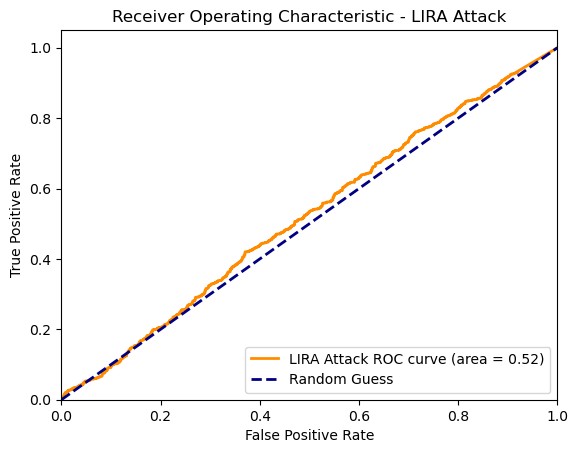

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import roc_auc_score
labels = np.concatenate([np.ones_like(train_lrs), np.zeros_like(test_lrs)])
lrs = np.concatenate([train_lrs, test_lrs])
labels = labels[np.logical_and(lrs > -10, lrs < 10)]
lrs = lrs[np.logical_and(lrs > -10, lrs < 10)]


# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, lrs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label=f'LIRA Attack ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - LIRA Attack')
plt.legend(loc="lower right")
plt.show()